In [1]:
using HybridSystems
include(joinpath(dirname(dirname(pathof(HybridSystems))), "examples", "cruise_control.jl"));

In [2]:
const va = 15.6
const vb = 24.5
const vc = 29.5
const v = (va, vb, vc)
const U = 4.
m0 = 500;
const H = 0.8;

In [ ]:
using SwitchOnSafety
const SOS = SwitchOnSafety;

┌ Info: Precompiling SwitchOnSafety [4b7ae085-addf-5b2e-b0f2-71171a701510]
└ @ Base loading.jl:1192


In [4]:
using Plots

In [5]:
function proj(ell, I)
    Qd = inv(ell.Q)
    Qdproj = Qd[I, I]
    Qproj = inv(Qdproj)
    SOS.Ellipsoid(Qproj, ell.c[I])
end

function pli(hs, p, i, I = [statedim(hs, 1)-1, statedim(hs, 1)])
    @assert length(I) == 2
    Plots.plot(Polyhedra.project(hs.invariants[i], I))
    Plots.plot!(proj(p[i], I))
end

pli (generic function with 2 methods)

In [4]:
using MathOptInterfaceMosek
using JuMP
sdp_factory = with_optimizer(MosekOptimizer, LOG=0);

In [5]:
using LightGraphs
const MOI = JuMP.MathOptInterface
function fullsolve(T, M, oneshot = false, onlyone = false, detcone=MOI.RootDetConeTriangle)
    N = 1 + (T+1) * length(v)
    hs = cruise_control_example(N, M, vmin = 5.0, v=(va, vb, vc), U=U, H=H, sym=false, m0=500);
    function hv(v)
        h = zeros(statedim(hs, 1))
        for i in 1:M
            h[2i] = (5 .+ v)/2
        end
        h[2M+1] = (5 .+ v)/2
        h
    end
    habc = SOS.InteriorPoint.(hv.(v))
    ha = habc[1]
    hi = [ha, ha, ha, ha, ha, ha, ha, ha, ha, ha]
    λ = Dict(Edge(a, b) => 1. for a in 1:N, b in 1:N)
    if oneshot
        getis(hs, sdp_factory, hi, λ = λ, detcone=detcone);
    else
        p = Vector{SwitchOnSafety.Ellipsoid{Float64}}(undef, N)
        for i in (onlyone ? (1:1) : (1:N))
            fillis!(p, i:i, hs, sdp_factory, hi, λ = λ, enabled=1:i, detcone=detcone)
            @show inv(det(p[i].Q))
        end
        p
    end
end

fullsolve (generic function with 4 methods)

In [6]:
P = Dict{Int, Vector{SwitchOnSafety.Ellipsoid{Float64}}}()

UndefVarError: UndefVarError: SwitchOnSafety not defined

In [7]:
T = 2
N = 1 + (T+1) * length(v)
for M in 1:10
    P[M] = fullsolve(T, M, false, true)
end

UndefVarError: UndefVarError: SOS not defined

In [10]:
N = 10
T = 2
M = 1
hs = cruise_control_example(N, M, vmin = 5., v=(va, vb, vc), U=U, H=H, T=T, sym=false, m0 = m0);
d = statedim(hs, 1);
_savefig(name, ext="eps") = Plots.savefig("/home/blegat/Dropbox/Research/Images/CruiseControl$name.$ext")

_savefig (generic function with 2 methods)

inv(det((P[M])[1].Q)) = 0.13034950335723902
inv(det((P[M])[1].Q)) = 0.0006457925264059678
inv(det((P[M])[1].Q)) = -9.144580389148809e-17
inv(det((P[M])[1].Q)) = 9.818840894560905e-32


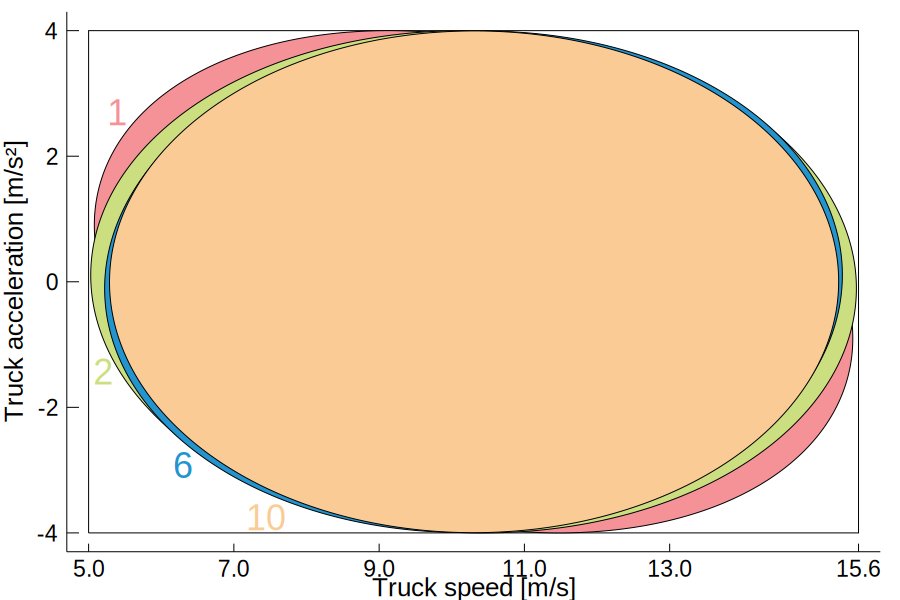

In [11]:
Id(d) = [d-1, d]
I = Id(d)
# Values taken from http://www.toutes-les-couleurs.com/code-couleur-rvb.php
troyes = Plots.RGBA(0.9961, 0.9922, 0.9412)
frambo = Plots.RGBA(0.7804, 0.1725, 0.2824)
lichen = Plots.RGBA(0.5216, 0.7569, 0.4941)
canard = Plots.RGBA(0.0157, 0.5451, 0.6039)
aurore = Plots.RGBA(((255, 203, 96) ./ 255)...)
# colors taken from https://previews.123rf.com/images/capacitorphoto/capacitorphoto1410/capacitorphoto141000191/32438941-Graph-Icon-color-set-illustration--Stock-Vector.jpg
red = Plots.RGBA(((0xf5, 0x92, 0x97) ./ 255)...)
gre = Plots.RGBA(((0xcb, 0xdf, 0x80) ./ 255)...)
blu = Plots.RGBA(((0x23, 0x94, 0xce) ./ 255)...)
ora = Plots.RGBA(((0xfa, 0xcb, 0x95) ./ 255)...)
yel = Plots.RGBA(((0xf2, 0xf0, 0x8b) ./ 255)...)
xmargin = 0.3
ymargin = 0.3
Plots.plot(guidefont=Plots.font(18), tickfont=Plots.font(16), size=(900, 600), grid=false, xlims=(5-xmargin, 15.6+xmargin), ylims=(-4-ymargin, 4+ymargin), xlabel="Truck speed [m/s]", ylabel="Truck acceleration [m/s²]", xticks = [5, 7, 9, 11, 13, 15.6])
Plots.plot!(Polyhedra.project(stateset(hs, 1), I), color=:white)
colors = [red, gre,
          gre, gre,
          blu, blu,
          blu, blu,
          ora, ora]
alpha = fill(1., 10)
for M in [1, 2, 6, 10]
    @show inv(det(P[M][1].Q))
    dd = 2M+2
    I = Id(dd)
    Plots.plot!(proj(P[M][1], I), fillalpha=alpha[M], color=colors[M])
end
fontsize = 24
Plots.annotate!(5.4,  2.7, Plots.text("1", fontsize, colors[1]))
Plots.annotate!(5.2, -1.43, Plots.text("2", fontsize, colors[2]))
Plots.annotate!(6.3, -2.92, Plots.text("6", fontsize, colors[6]))
Plots.annotate!(7.45, -3.75, Plots.text("10", fontsize, colors[10]))
#@show inv(det(p[N].Q))
#Plots.plot!(proj(p[N], I))
#_savefig("Sets")
Plots.plot!()

In [ ]:
MM = 1:10
tell = [0.10468482971191406, 0.2330489158630371, 0.8677887916564941, 1.4519941806793213, 2.107150077819824, 3.5698659420013428, 4.80554986000061, 7.2393341064453125, 11.002917051315308, 15.073602199554443]
# 0.115419   0.245829   0.699803
# 1.41012    0.583312   1.60318 
# 1.63905    1.34177    3.57714 
# 2.93782    2.6325     5.64993 
# 2.4405     3.54338    9.20356 
# 3.57665    6.54242   16.2175  
# 5.81741   11.6776    27.5883  
# 6.79864   17.2622    45.1504  
# 9.08597   29.3919    69.7584  
# 0.0        0.0        0.0
tpoly2 =[
 0.13857    0.34833    0.885522
 0.245551   0.613526   2.01404 
 0.418676   1.16248    3.58055 
 0.814852   2.05653    5.71168 
 1.17044    2.95415    8.6016  
 1.76629    4.74113   11.3175  
 2.31273    6.6922    16.0757  
 2.88756    8.71237   22.6182  
 3.67838   11.8209    29.5     
 4.8712    16.119     41.0898]
tpoly = [ # H redundancy removal, CDDLib only, Dell laptop
  0.13682    0.290317
  0.424803   0.646405
  0.637992   1.2339 
  0.994851   2.28653 
  2.59906    3.7554  
  3.39291    6.78438 
  4.60605   10.9812  
  6.43151   17.4433  
  8.70048   28.4263  
 12.212     43.0176
]
# colors taken from https://previews.123rf.com/images/capacitorphoto/capacitorphoto1410/capacitorphoto141000191/32438941-Graph-Icon-color-set-illustration--Stock-Vector.jpg
red = Plots.RGBA(((0xf5, 0x92, 0x97) ./ 255)...)
gre = Plots.RGBA(((0xcb, 0xdf, 0x80) ./ 255)...)
blu = Plots.RGBA(((0x23, 0x94, 0xce) ./ 255)...)
ora = Plots.RGBA(((0xfa, 0xcb, 0x95) ./ 255)...)
yel = Plots.RGBA(((0xf2, 0xf0, 0x8b) ./ 255)...)
#font = ("sans-serif",12,:hcenter,:vcenter,0.0,Plots.RGB{Plots.U8}(0.0,0.0,0.0))
w = 2
ms = 6
Plots.plot(xlabel = "Number of trailers", ylabel="Solve Time [s]", xticks=1:10, tickfont=Plots.font(10), legendfont=Plots.font(12), guidefont=Plots.font(12))
Plots.plot!(MM, tell, color=blu, label="", linewidth=w)
Plots.scatter!(MM, tell, color=blu, markersize=6, markerstrokewidth=0, label="Ellipsoidal : Full computation")
Plots.plot!(MM, sum(tpoly[:,1:2], 2), color=ora, label="", linewidth=w)
Plots.scatter!(MM, sum(tpoly[:,1:2], 2), color=ora, markersize=6, markerstrokewidth=0, label="Polyhedral : only 2 iterations")
_savefig("Benchmark", "png")
Plots.plot!()

In [ ]:
using JuMP
const MOI = MathOptInterface

$(x-c)^T Q (x-c) \le 1 \Leftrightarrow \lVert L(x-c) \rVert \le 1 \Leftrightarrow (1, L(x-c)) \text{ SOC}$

In [ ]:
function elltosoc(p::SOS.Ellipsoid)
    U, S, V = svd(p.Q)
    L = diagm(sqrt.(S)) * V'
    @show p.c
    x -> L * (x - p.c)
end
soc = elltosoc.(fullsolve(T, M, false, false))

In [ ]:
using JuMP
const MOI = MathOptInterface

function mpcstep(modes, x0, y0, usesoc, usetol)
    m = Model()
    nt = length(modes)
    @variable m y[1:nt]
    @variable m x[1:nt, 1:d]
    @variable m u[1:(nt-1)]
    @constraint m x[1, :] .== x0
    @constraint m y[1] == y0
    if usetol
        @variable m tol >= 0
    end

    for i in 1:nt
        q = modes[i]
        for h in ineqs(hs.invariants[q])
            @constraint m dot(x[i, :], h.a) <= h.β + (usetol ? tol : 0.)
        end
        if usesoc
            @constraint m [1; soc[q](x[i, :])] in MOI.SecondOrderCone(1+d)
        end
        if i < nt
            s = modes[i+1]
            σ = symbol(hs.automaton, LightGraphs.Edge(q, s))
            r = hs.resetmaps[σ]
            @constraint m x[i+1, :] .== r.A * x[i, :] + r.B * u[i]
            if σ == 1
                @constraint m y[i+1] == y[i] + (H/T) * x[i, d-1]
            else
                @constraint m y[i+1] == y[i]
            end
        end
    end
    @objective m Max y[end] - (usetol ? 1000tol : 0.)
    JuMP.attach(m, sdpsolver())
    JuMP.solve(m)

    @assert JuMP.terminationstatus(m) == MOI.Success

    JuMP.dualstatus(m), JuMP.resultvalue.(x)[2:end,:], JuMP.resultvalue.(y)[2:end]
end

In [ ]:
function solvempc(modes, nsteps = 1, useellipsoids = false)
    nt = length(modes)
    y = Vector{Float64}(nt)
    x = Matrix{Float64}(nt, d)
    x[1, :] = [repmat([0., 10.], M); 10.; 0.]
    y[1] = -10. * (H/T)
    last = nt
    for i in 1:(nt-1)
        j = min(nt, i + nsteps)
        _step(usetol) = mpcstep(modes[i:j], x[i, :], y[i], useellipsoids, usetol)
        ds, X, Y = _step(false)
        if ds == MOI.InfeasibilityCertificate
            ds, X, Y = _step(true)
        end
        while ds == MOI.InfeasibilityCertificate && nsteps > 1
            nsteps -= 1
            ds, X, Y = _step(true)
        end
        if ds == MOI.InfeasibilityCertificate || !(X[1, :] in hs.invariants[modes[i+1]])
            last = i
            break
        else
            x[i+1, :] = X[1, :]
            y[i+1] = Y[1]
        end
    end
    x[2:last, :], y[2:last]
end

In [ ]:
nt = 77
nN = div(nt, 2)
modes = [fill(N, nN); 3; 2; fill(1, nt-2-nN)];
t = [0.]
tswitch = Float64[]
for i in 2:(nt-1)
    σ = symbol(hs.automaton, LightGraphs.Edge(modes[i], modes[i+1]))
    if σ == 1
        push!(t, t[end] + H/T)
    else
        push!(t, t[end])
        tswitch = [t[end], t[end]]
    end
end

In [ ]:
t

In [ ]:
last = map(i -> length(solvempc(modes, i)[2]), 3:nt)

In [ ]:
Plots.plot(3:nt, last)

In [ ]:
XYok = Dict{String, Tuple{Matrix{Float64}, Vector{Float64}}}()
XYko = Dict{String, Tuple{Matrix{Float64}, Vector{Float64}}}();

In [ ]:
XYok["unsafe optimal"] = solvempc(modes, nt);

In [ ]:
XYok["unsafe 23"] = solvempc(modes, 23);

In [ ]:
XYko["unsafe 22"] = solvempc(modes, 22);

In [ ]:
XYko["unsafe 8"] = solvempc(modes, 8);

In [ ]:
XYok["safe 8"] = solvempc(modes, 8, true);

In [ ]:
XYok["safe 3"] = solvempc(modes, 3, true);

In [ ]:
#XY = [("unsafe 8", XYko["unsafe 8"])];
XY = XYok;
plotsize = (800, 400);

In [ ]:
Plots.plot(size=(800, 400), xlabel="Time [s]", ylabel="Truck position [m]")
for (s, (x, y)) in XY
    Plots.plot!(t, y, label=s)
end
Plots.plot!(tswitch .+ H, collect(extrema(XY["unsafe optimal"][2])), label="")
#_savefig("Position")

The last value of the speed does not impact `y[end]` so the value taken by the solver is arbitrary

In [ ]:
Plots.plot(size=(800, 400), [t[1], tswitch[1]+H], [35, 35], size=plotsize, label="", xlabel="Time [s]", ylabel="Speed [m/s]")
mini = Inf
maxi = 35
for (s, (x, y)) in XY
    v1 = x[:,d-2]
    v0 = x[:,d-1]
    #:none,:auto,:circle,:rect,:star5,:diamond,:hexagon,:cross,:xcross,:utriangle,:dtriangle,:rtriangle,:ltriangle,:pentagon,:heptagon,:octagon,:star4,:star6,:star7,:star8,:vline,:hline,:+,:x].
    issafe = s[1] == 's'
    ms = 5
    Plots.scatter!(t[1:end-1], v1[1:end-1], label="Trailer speed $s", markersize=ms, markershape=issafe ? :diamond : :utriangle, markerstrokewidth=0)
    Plots.scatter!(t[1:end-1], v0[1:end-1], label="Truck speed $s", markersize=ms, markershape=issafe ? :circle : :rtriangle, markerstrokewidth=0)
    mini = min(mini, minimum(v1), minimum(v0))
    maxi = max(maxi, maximum(v1), maximum(v0))
end
#Plots.plot!(tswitch, [mini, maxi])
Plots.plot!(tswitch .+ H, [mini, maxi], label="")
Plots.plot!([tswitch[1]+H, t[end]], [va, va], label="")
#_savefig("Speed")

The last two values of the acceleration does not impact `y[end]` so the values taken by the solver are arbitrary

In [ ]:
Plots.plot(size=plotsize, ylim=(-4.1, 4.1), xlabel="Time [s]", ylabel="Acceleration [m/s²]")
for (s, (x, y)) in XY
    u = x[:, 4]
    issafe = s[1] == 's'
    Plots.scatter!(t[1:end-2], u[1:end-2], label="Truck acceleration $s", markersize=7, markershape=issafe ? :circle : :rtriangle, markerstrokewidth=0)
end
Plots.plot!(tswitch .+ H, [-U, U], label="")
#_savefig("Acceleration")

In [ ]:
Plots.plot(yticks = [-0.5, -0.25, 0.0, 0.25, 0.5], ylims=(-0.55, 0.55), size=plotsize, xlabel="Time [s]", ylabel="Displacement [m]")
for (s, (x, y)) in XY
    dist = x[:, 1]
    Plots.plot!(t[1:end-2], dist, label="Spring displacement $s")
end
Plots.plot!(tswitch .+ H, [-.5, .5], label="")
#_savefig("Displacement")